In [2]:
#Unzipping the zip files with user, tags and ratings file

!wget -O moviedataset.zip https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
print('unziping ...')
!unzip -o -j moviedataset.zip 

--2022-05-22 19:31:53--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-05-22 19:31:54 (6.35 MB/s) - ‘moviedataset.zip’ saved [978202/978202]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: tags.csv                
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: movies.csv              


In [20]:
#Importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [5]:
#Storing the movie information into a pandas dataframe
movies = pd.read_csv('movies.csv')

#Storing the user information into a pandas dataframe
ratings = pd.read_csv('ratings.csv')

#Storing the user information into a pandas dataframe
tags = pd.read_csv('tags.csv')

#Displaying the head function of movies dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#Displaying the size of the ratings dataset
ratings.shape

(100836, 4)

In [7]:
#Displaying random 5 samples from ratings dataset
ratings.sample(5)

,userId,movieId,rating,timestamp
17534,111,44840,2.5,1516153280
602,6,92,4.0,845555454
59849,387,4467,3.5,1094876718
85528,555,1855,2.0,978747598
11866,73,45221,4.0,1464198899


In [8]:
movies.sample(5)

,movieId,title,genres
1957,2596,SLC Punk! (1998),Comedy|Drama
7801,92243,"Flowers of War, The (Jin líng shí san chai) (2...",Drama|War
4356,6373,Bruce Almighty (2003),Comedy|Drama|Fantasy|Romance
2661,3563,"Crow: Salvation, The (2000)",Action|Horror
3057,4093,Cop (1988),Thriller


In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


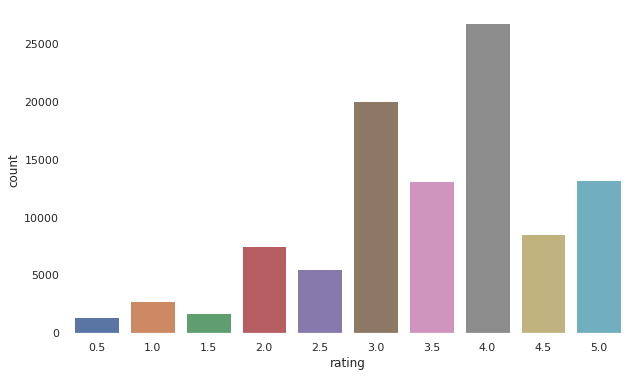

In [13]:
plt.figure(figsize=(10,6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(ratings['rating'].fillna(ratings['rating'].median()))

In [14]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first', 
                                                         'genres':'first', 
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [18]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: genres, dtype: int64

###TF-IDF Function for Content Based Filtering

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [24]:
s = "Animation Children's Comedy"
tf_wrong = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
tf_wrong.fit([s])
tf_wrong.get_feature_names()
# ['animation', 'animation children', 'children', 'children comedy', 'comedy']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['animation', 'animation children', 'children', 'children comedy', 'comedy']

In [25]:
[c for i in range(1,2) for c in combinations(s.split(), r=i)]

[('Animation',), ("Children's",), ('Comedy',)]

In [26]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape
# (3883, 353)

(9742, 783)

In [27]:
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names(), index=movies.title).sample(5, axis=1).sample(10, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,"(Adventure, Drama, Mystery)","(Animation, Comedy, Sci-Fi)","(Action, Documentary)","(Horror, Sci-Fi, IMAX)","(Action, Crime, Romance)"
title,,,,,
Pirates of the Caribbean: Dead Men Tell No Tales (2017),0.0,0.0,0.0,0.0,0.0
22 Jump Street (2014),0.0,0.0,0.0,0.0,0.0
One True Thing (1998),0.0,0.0,0.0,0.0,0.0
In the Heat of the Night (1967),0.0,0.0,0.0,0.0,0.0
Zookeeper (2011),0.0,0.0,0.0,0.0,0.0
Hellraiser (1987),0.0,0.0,0.0,0.0,0.0
Beethoven's 2nd (1993),0.0,0.0,0.0,0.0,0.0
Ghosts of Mars (2001),0.0,0.0,0.0,0.0,0.0
...All the Marbles (1981),0.0,0.0,0.0,0.0,0.0


In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [29]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (9742, 9742)


title,Baywatch (2017),True Grit (2010),"Ballad of Narayama, The (Narayama bushiko) (1983)",Wet Hot American Summer (2001),"Troll Hunter, The (Trolljegeren) (2010)"
title,,,,,
Toy Story (1995),0.03,0.0,0.00,0.08,0.07
Jumanji (1995),0.00,0.0,0.00,0.00,0.15
Grumpier Old Men (1995),0.15,0.0,0.00,0.40,0.00
Waiting to Exhale (1995),0.09,0.0,0.22,0.24,0.00
Father of the Bride Part II (1995),0.37,0.0,0.00,1.00,0.00
...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.29,0.0,0.00,0.11,0.09
No Game No Life: Zero (2017),0.06,0.0,0.00,0.17,0.14
Flint (2017),0.00,0.0,1.00,0.00,0.00


###Building the logic for the recommender

In [30]:
def genre_recommendations(i, M, items, k=10):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

###Testing the recommender

In [31]:
movies[movies.title.eq('2001: A Space Odyssey (1968)')]

,movieId,title,genres
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi


In [32]:
genre_recommendations('2001: A Space Odyssey (1968)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,A.I. Artificial Intelligence (2001),Adventure|Drama|Sci-Fi
1,The Martian (2015),Adventure|Drama|Sci-Fi
2,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi
3,"20,000 Leagues Under the Sea (1954)",Adventure|Drama|Sci-Fi
4,Close Encounters of the Third Kind (1977),Adventure|Drama|Sci-Fi
5,"Philadelphia Experiment, The (1984)",Adventure|Drama|Sci-Fi
6,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
7,Enemy Mine (1985),Adventure|Drama|Sci-Fi
8,Until the End of the World (Bis ans Ende der W...,Adventure|Drama|Sci-Fi
9,War for the Planet of the Apes (2017),Action|Adventure|Drama|Sci-Fi


In [33]:
print(movies[movies.title.eq('Contact (1997)')])

      movieId           title        genres
1187     1584  Contact (1997)  Drama|Sci-Fi


In [34]:
genre_recommendations('Contact (1997)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,SORI: Voice from the Heart (2016),Drama|Sci-Fi
1,"Brother from Another Planet, The (1984)",Drama|Sci-Fi
2,Monsters (2010),Drama|Sci-Fi
3,Primer (2004),Drama|Sci-Fi
4,Babylon 5: Thirdspace (1998),Drama|Sci-Fi
5,Powder (1995),Drama|Sci-Fi
6,Fahrenheit 451 (1966),Drama|Sci-Fi
7,Melancholia (2011),Drama|Sci-Fi
8,Babylon 5: The River of Souls (1998),Drama|Sci-Fi
9,1984 (Nineteen Eighty-Four) (1984),Drama|Sci-Fi


In [35]:
movies[movies.title.eq('Jungle Book, The (1967)')]

,movieId,title,genres
1543,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical


In [36]:
genre_recommendations('Jungle Book, The (1967)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,Ferngully: The Last Rainforest (1992),Animation|Children|Comedy|Musical
1,"All Dogs Christmas Carol, An (1998)",Animation|Children|Comedy|Musical
2,"Claymation Christmas Celebration, A (1987)",Animation|Children|Comedy|Musical
3,Alvin and the Chipmunks: The Squeakquel (2009),Animation|Children|Comedy|Musical
4,Steamboat Willie (1928),Animation|Children|Comedy|Musical
5,Oliver & Company (1988),Adventure|Animation|Children|Comedy|Musical
6,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
7,Robin Hood (1973),Adventure|Animation|Children|Comedy|Musical
8,Hercules (1997),Adventure|Animation|Children|Comedy|Musical
9,"Many Adventures of Winnie the Pooh, The (1977)",Animation|Children|Musical


In [37]:
movies[movies.title.eq('Saving Private Ryan (1998)')]

,movieId,title,genres
1503,2028,Saving Private Ryan (1998),Action|Drama|War


In [38]:
genre_recommendations('Saving Private Ryan (1998)', cosine_sim_df, movies[['title', 'genres']])

,title,genres
0,"Monuments Men, The (2014)",Action|Drama|War
1,Tae Guk Gi: The Brotherhood of War (Taegukgi h...,Action|Drama|War
2,Inescapable (2012),Action|Drama|War
3,"Boot, Das (Boat, The) (1981)",Action|Drama|War
4,Behind Enemy Lines (2001),Action|Drama|War
5,All Quiet on the Western Front (1930),Action|Drama|War
6,Max Manus (2008),Action|Drama|War
7,Fury (2014),Action|Drama|War
8,Zulu (1964),Action|Drama|War
9,Memphis Belle (1990),Action|Drama|War
